<a href="https://colab.research.google.com/github/nitin-vig/ERAv4S8/blob/main/Cifar_100_with_Resnt50_AdamW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Cifar 100 with Resnt50

In [90]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

**Compute Mean and Standard Deviation for Normalization of data**. Commented as it is needed only once

In [91]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def get_mean_and_std(dataloader):
#     """
#     Calculate the mean and standard deviation of a dataset.

#     Args:
#         dataloader (DataLoader): The DataLoader for the dataset.

#     Returns:
#         tuple: The mean and standard deviation tensors for each channel.
#     """
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader, desc="Calculating mean and std"):
#         # Mean over batch, height, and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     # Std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     return mean, std

# # 1. Load the dataset without normalization (only convert to tensor)
# # This will automatically download the dataset if it's not present
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# # 2. Create a DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# # 3. Get the mean and standard deviation
# mean, std = get_mean_and_std(train_loader)

# print('Calculated Mean:', mean)
# print('Calculated Standard Deviation:', std)

# 100%|██████████| 169M/169M [00:06<00:00, 27.9MB/s]
# Calculating mean and std: 100%|██████████| 391/391 [00:07<00:00, 50.50it/s]
# Calculated Mean: tensor([0.5070, 0.4865, 0.4409])
# Calculated Standard Deviation: tensor([0.2673, 0.2564, 0.2761])

In [92]:
# Train Phase transformations
# Define your Albumentations pipeline
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

CIFAR_MEAN = (0.5070, 0.4865, 0.4409)
CIFAR_STD  = (0.2673, 0.2564, 0.2761)


train_alb = A.Compose([
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
    A.RandomCrop(32, 32, p=1.0),  # Then crop
    A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.OneOf([
        A.CoarseDropout(
            max_holes=1,
            max_height=16,
            max_width=16,
            min_height=8,
            min_width=8,
            fill_value=tuple([int(x * 255) for x in [0.5071, 0.4867, 0.4408]]),
            p=0.75
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),
    ], p=0.5),
    A.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ToTensorV2(),
])

# test: only normalize + tensor
test_alb = A.Compose([
    A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
    ToTensorV2(),
])

# wrapper functions for torchvision CIFAR100 dataset
def alb_train_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return train_alb(image=img)["image"]

def alb_test_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return test_alb(image=img)["image"]



/tmp/ipython-input-1334562076.py:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
/tmp/ipython-input-1334562076.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipython-input-1334562076.py:26: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


In [93]:
train = datasets.CIFAR100('./data', train=True, download=True, transform=alb_train_transform)
test = datasets.CIFAR100('./data', train=False, download=True, transform=alb_test_transform)

In [94]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


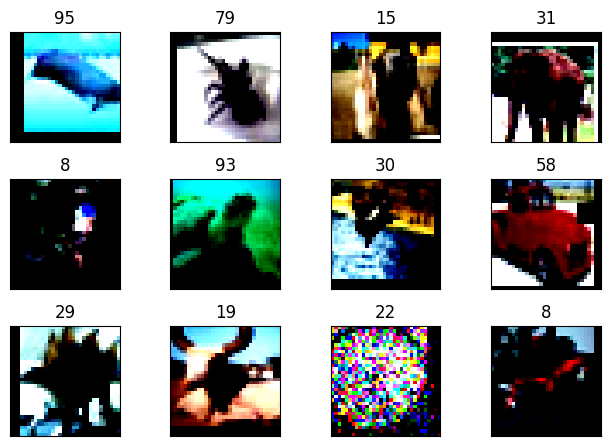

In [95]:

import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(batch_data[i].permute(1,2,0))

  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [96]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from tqdm import tqdm


# Bottleneck block (same as before)
class Bottleneck(nn.Module):
 expansion = 4

 def __init__(self, in_channels, out_channels, stride=1, downsample=None):
  super(Bottleneck, self).__init__()
  self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
  self.bn1 = nn.BatchNorm2d(out_channels)

  self.conv2 = nn.Conv2d(
   out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
  )
  self.bn2 = nn.BatchNorm2d(out_channels)

  self.conv3 = nn.Conv2d(
   out_channels, out_channels * self.expansion, kernel_size=1, bias=False
  )
  self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

  self.relu = nn.ReLU(inplace=True)
  self.downsample = downsample

 def forward(self, x):
  identity = x

  out = self.conv1(x)
  out = self.bn1(out)
  out = self.relu(out)

  out = self.conv2(out)
  out = self.bn2(out)
  out = self.relu(out)

  out = self.conv3(out)
  out = self.bn3(out)

  if self.downsample is not None:
   identity = self.downsample(x)

  out += identity
  out = self.relu(out)
  return out


# ResNet tailored for CIFAR (no initial 7x7 stride-2 conv + no maxpool)
class ResNetCIFAR(nn.Module):
 def __init__(self, block, layers, num_classes=100):
  super(ResNetCIFAR, self).__init__()
  self.in_channels = 64

  # Adjusted first conv for CIFAR (3x3, stride=1)
  self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
  self.bn1 = nn.BatchNorm2d(64)
  self.relu = nn.ReLU(inplace=True)

  # NOTE: we do NOT use the 7x7 stride-2 conv or the 3x3 maxpool used for ImageNet
  # Stage layers
  self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
  self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
  self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
  self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

  self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
  self.fc = nn.Linear(512 * block.expansion, num_classes)

  # Weight initialization
  for m in self.modules():
   if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
   elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)

 def _make_layer(self, block, out_channels, blocks, stride=1):
  downsample = None
  if stride != 1 or self.in_channels != out_channels * block.expansion:
   downsample = nn.Sequential(
    nn.Conv2d(
     self.in_channels,
     out_channels * block.expansion,
     kernel_size=1,
     stride=stride,
     bias=False,
    ),
    nn.BatchNorm2d(out_channels * block.expansion),
   )

  layers = []
  layers.append(block(self.in_channels, out_channels, stride, downsample))
  self.in_channels = out_channels * block.expansion
  for _ in range(1, blocks):
   layers.append(block(self.in_channels, out_channels))

  return nn.Sequential(*layers)

 def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  # no maxpool

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  x = self.avgpool(x)
  x = torch.flatten(x, 1)
  x = self.fc(x)
  return x


def resnet50_cifar(num_classes=100):
 return ResNetCIFAR(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

In [97]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet50_cifar().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1,

In [98]:
import torch

def topk_accuracy(output, target, k=5):
    """
    Calculates the top-k accuracy for a given output and target.

    Args:
        output (torch.Tensor): The model's raw output logits, typically from the last layer.
        target (torch.Tensor): The ground-truth labels.
        k (int): The number of top predictions to consider.

    Returns:
        float: The top-k accuracy.
    """
    with torch.no_grad():
        # Get the top k predictions
        _, topk_preds = output.topk(k, dim=1, largest=True, sorted=True)

        # Reshape the target tensor for comparison
        target_reshaped = target.view(1, -1).expand_as(topk_preds)

        # Check if any of the top k predictions match the true label
        correct = (topk_preds == target_reshaped)

        # Calculate the number of correct predictions
        correct_count = correct.any(dim=0).sum().item()

        # Return the accuracy as a percentage
        return (correct_count / target.size(0))


In [99]:

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) ## Learning: adjust LR to a smaller value after every 5 epochs for fine tuning
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=100, anneal_strategy='cos')

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=0.00432,
#     epochs=50,
#     anneal_strategy='cos',
#     steps_per_epoch=len(train_loader),
#     pct_start=0.3,
#     div_factor=10,
#     final_div_factor=1e4
# )

In [100]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_top5_acc = [] # New list to store top-5 accuracy

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.cross_entropy(y_pred, target,label_smoothing=0.1)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
# Update the learning rate After each batch if doing OnecycleLR else after each epoch
scheduler.step()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct_top1 = 0
    correct_top5 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # Top-1 accuracy calculation
            pred_top1 = output.argmax(dim=1, keepdim=True)
            correct_top1 += pred_top1.eq(target.view_as(pred_top1)).sum().item()

            # Top-5 accuracy calculation
            # correct_top5 += topk_accuracy(output, target, k=5)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    top1_acc = 100. * correct_top1 / len(test_loader.dataset)
    # top5_acc = 100. * correct_top5 / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f} ,Top-1 Accuracy: {correct_top1}/{len(test_loader.dataset)} ({top1_acc:.2f}%)%\n')

    test_acc.append(top1_acc)
    # test_top5_acc.append(top5_acc)


In [101]:
# !pip install torch-lr-finder


In [102]:
# import torch
# from torch import nn, optim
# from torch_lr_finder import LRFinder
# import matplotlib.pyplot as plt

# # 3. Instantiate model, optimizer, and criterion
# device = "cuda" if torch.cuda.is_available() else "cpu"
# # Assuming 'model' is already defined and on the correct device
# # e.g., model = resnet34_cifar().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-7)  # Start with a very small LR
# criterion = nn.CrossEntropyLoss()

# # 4. Run the LR finder
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=0.1, num_iter=300)
# # 5. Plot the results
# lr_finder.plot()

# # 6. Reset the model and optimizer to their initial states
# lr_finder.reset()
# #>>>>>>>>4.32e-03 for batch size 128,
# # LR: 9.05E-03 for batch size 256
# ##Suggested LR: 7.88E-03 for  batch size 512


In [103]:
torch.autograd.set_detect_anomaly(True)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=3.964966297149658 Batch_id=195 Accuracy=7.16: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 3.7062 ,Top-1 Accuracy: 1196/10000 (11.96%)%

EPOCH: 2


Loss=3.6930575370788574 Batch_id=195 Accuracy=16.08: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 3.1890 ,Top-1 Accuracy: 2181/10000 (21.81%)%

EPOCH: 3


Loss=3.5002551078796387 Batch_id=195 Accuracy=24.59: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 18.2392 ,Top-1 Accuracy: 2753/10000 (27.53%)%

EPOCH: 4


Loss=2.985780715942383 Batch_id=195 Accuracy=30.74: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 2.6567 ,Top-1 Accuracy: 3331/10000 (33.31%)%

EPOCH: 5


Loss=2.615804672241211 Batch_id=195 Accuracy=37.64: 100%|██████████| 196/196 [01:34<00:00,  2.09it/s]



Test set: Average loss: 2.3519 ,Top-1 Accuracy: 3961/10000 (39.61%)%

EPOCH: 6


Loss=2.6683061122894287 Batch_id=195 Accuracy=42.77: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 2.1055 ,Top-1 Accuracy: 4415/10000 (44.15%)%

EPOCH: 7


Loss=2.63608717918396 Batch_id=195 Accuracy=46.70: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 2.1821 ,Top-1 Accuracy: 4503/10000 (45.03%)%

EPOCH: 8


Loss=2.349241018295288 Batch_id=195 Accuracy=50.59: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.9224 ,Top-1 Accuracy: 4965/10000 (49.65%)%

EPOCH: 9


Loss=2.2405354976654053 Batch_id=195 Accuracy=53.57: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.8116 ,Top-1 Accuracy: 5183/10000 (51.83%)%

EPOCH: 10


Loss=2.328219413757324 Batch_id=195 Accuracy=55.99: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]



Test set: Average loss: 1.6180 ,Top-1 Accuracy: 5622/10000 (56.22%)%

EPOCH: 11


Loss=2.1083405017852783 Batch_id=195 Accuracy=58.60: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.5715 ,Top-1 Accuracy: 5761/10000 (57.61%)%

EPOCH: 12


Loss=2.00890851020813 Batch_id=195 Accuracy=60.84: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.5895 ,Top-1 Accuracy: 5754/10000 (57.54%)%

EPOCH: 13


Loss=2.1160078048706055 Batch_id=195 Accuracy=62.87: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.5873 ,Top-1 Accuracy: 5797/10000 (57.97%)%

EPOCH: 14


Loss=1.9782414436340332 Batch_id=195 Accuracy=64.32: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]



Test set: Average loss: 1.4413 ,Top-1 Accuracy: 6133/10000 (61.33%)%

EPOCH: 15


Loss=2.0952887535095215 Batch_id=195 Accuracy=66.42: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.4113 ,Top-1 Accuracy: 6269/10000 (62.69%)%

EPOCH: 16


Loss=2.022798776626587 Batch_id=195 Accuracy=67.68: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.3600 ,Top-1 Accuracy: 6344/10000 (63.44%)%

EPOCH: 17


Loss=1.7496129274368286 Batch_id=195 Accuracy=69.41: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.3465 ,Top-1 Accuracy: 6430/10000 (64.30%)%

EPOCH: 18


Loss=1.6562418937683105 Batch_id=195 Accuracy=70.90: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.4056 ,Top-1 Accuracy: 6333/10000 (63.33%)%

EPOCH: 19


Loss=1.8577455282211304 Batch_id=195 Accuracy=72.24: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]



Test set: Average loss: 1.4125 ,Top-1 Accuracy: 6393/10000 (63.93%)%

EPOCH: 20


Loss=1.8185133934020996 Batch_id=195 Accuracy=73.69: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.3132 ,Top-1 Accuracy: 6558/10000 (65.58%)%

EPOCH: 21


Loss=1.6372913122177124 Batch_id=195 Accuracy=74.82: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.3230 ,Top-1 Accuracy: 6470/10000 (64.70%)%

EPOCH: 22


Loss=1.8196656703948975 Batch_id=195 Accuracy=76.12: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2289 ,Top-1 Accuracy: 6752/10000 (67.52%)%

EPOCH: 23


Loss=1.7683608531951904 Batch_id=195 Accuracy=77.49: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2581 ,Top-1 Accuracy: 6659/10000 (66.59%)%

EPOCH: 24


Loss=1.6367754936218262 Batch_id=195 Accuracy=78.77: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]



Test set: Average loss: 1.2314 ,Top-1 Accuracy: 6739/10000 (67.39%)%

EPOCH: 25


Loss=1.6420657634735107 Batch_id=195 Accuracy=79.44: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.3662 ,Top-1 Accuracy: 6584/10000 (65.84%)%

EPOCH: 26


Loss=1.5651440620422363 Batch_id=195 Accuracy=80.37: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2791 ,Top-1 Accuracy: 6674/10000 (66.74%)%

EPOCH: 27


Loss=1.591516137123108 Batch_id=195 Accuracy=80.70: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2523 ,Top-1 Accuracy: 6832/10000 (68.32%)%

EPOCH: 28


Loss=1.5521619319915771 Batch_id=195 Accuracy=82.02: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2137 ,Top-1 Accuracy: 6798/10000 (67.98%)%

EPOCH: 29


Loss=1.443932294845581 Batch_id=195 Accuracy=83.18: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1773 ,Top-1 Accuracy: 6992/10000 (69.92%)%

EPOCH: 30


Loss=1.6058552265167236 Batch_id=195 Accuracy=84.34: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1969 ,Top-1 Accuracy: 6930/10000 (69.30%)%

EPOCH: 31


Loss=1.3472199440002441 Batch_id=195 Accuracy=84.90: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2219 ,Top-1 Accuracy: 6927/10000 (69.27%)%

EPOCH: 32


Loss=1.2491834163665771 Batch_id=195 Accuracy=85.48: 100%|██████████| 196/196 [01:38<00:00,  1.99it/s]



Test set: Average loss: 1.2357 ,Top-1 Accuracy: 6899/10000 (68.99%)%

EPOCH: 33


Loss=1.2368626594543457 Batch_id=195 Accuracy=86.55: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1721 ,Top-1 Accuracy: 7061/10000 (70.61%)%

EPOCH: 34


Loss=1.2587451934814453 Batch_id=195 Accuracy=87.20: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2283 ,Top-1 Accuracy: 6990/10000 (69.90%)%

EPOCH: 35


Loss=1.3597486019134521 Batch_id=195 Accuracy=87.23: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2181 ,Top-1 Accuracy: 6976/10000 (69.76%)%

EPOCH: 36


Loss=1.3507905006408691 Batch_id=195 Accuracy=87.45: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2959 ,Top-1 Accuracy: 6830/10000 (68.30%)%

EPOCH: 37


Loss=1.1790932416915894 Batch_id=195 Accuracy=87.77: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2382 ,Top-1 Accuracy: 6917/10000 (69.17%)%

EPOCH: 38


Loss=1.2720849514007568 Batch_id=195 Accuracy=88.00: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2530 ,Top-1 Accuracy: 6955/10000 (69.55%)%

EPOCH: 39


Loss=1.1637111902236938 Batch_id=195 Accuracy=88.79: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2177 ,Top-1 Accuracy: 7061/10000 (70.61%)%

EPOCH: 40


Loss=1.26515531539917 Batch_id=195 Accuracy=89.63: 100%|██████████| 196/196 [01:37<00:00,  2.02it/s]



Test set: Average loss: 1.1932 ,Top-1 Accuracy: 7041/10000 (70.41%)%

EPOCH: 41


Loss=1.2666442394256592 Batch_id=195 Accuracy=89.58: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2035 ,Top-1 Accuracy: 7112/10000 (71.12%)%

EPOCH: 42


Loss=1.3377957344055176 Batch_id=195 Accuracy=90.02: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]



Test set: Average loss: 1.2080 ,Top-1 Accuracy: 7080/10000 (70.80%)%

EPOCH: 43


Loss=1.1525561809539795 Batch_id=195 Accuracy=90.26: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2462 ,Top-1 Accuracy: 6998/10000 (69.98%)%

EPOCH: 44


Loss=1.253391981124878 Batch_id=195 Accuracy=90.44: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2379 ,Top-1 Accuracy: 6997/10000 (69.97%)%

EPOCH: 45


Loss=1.2284057140350342 Batch_id=195 Accuracy=90.65: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2136 ,Top-1 Accuracy: 7117/10000 (71.17%)%

EPOCH: 46


Loss=1.227590560913086 Batch_id=195 Accuracy=90.89: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2485 ,Top-1 Accuracy: 7013/10000 (70.13%)%

EPOCH: 47


Loss=1.3882008790969849 Batch_id=195 Accuracy=90.82: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]



Test set: Average loss: 1.3297 ,Top-1 Accuracy: 6818/10000 (68.18%)%

EPOCH: 48


Loss=1.3292077779769897 Batch_id=195 Accuracy=85.32: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]



Test set: Average loss: 1.2268 ,Top-1 Accuracy: 7059/10000 (70.59%)%

EPOCH: 49


Loss=1.1238197088241577 Batch_id=195 Accuracy=90.60: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]



Test set: Average loss: 1.2360 ,Top-1 Accuracy: 7081/10000 (70.81%)%

EPOCH: 50


Loss=1.1494756937026978 Batch_id=195 Accuracy=91.35: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]



Test set: Average loss: 1.1914 ,Top-1 Accuracy: 7155/10000 (71.55%)%



Text(0.5, 1.0, 'Test Accuracy')

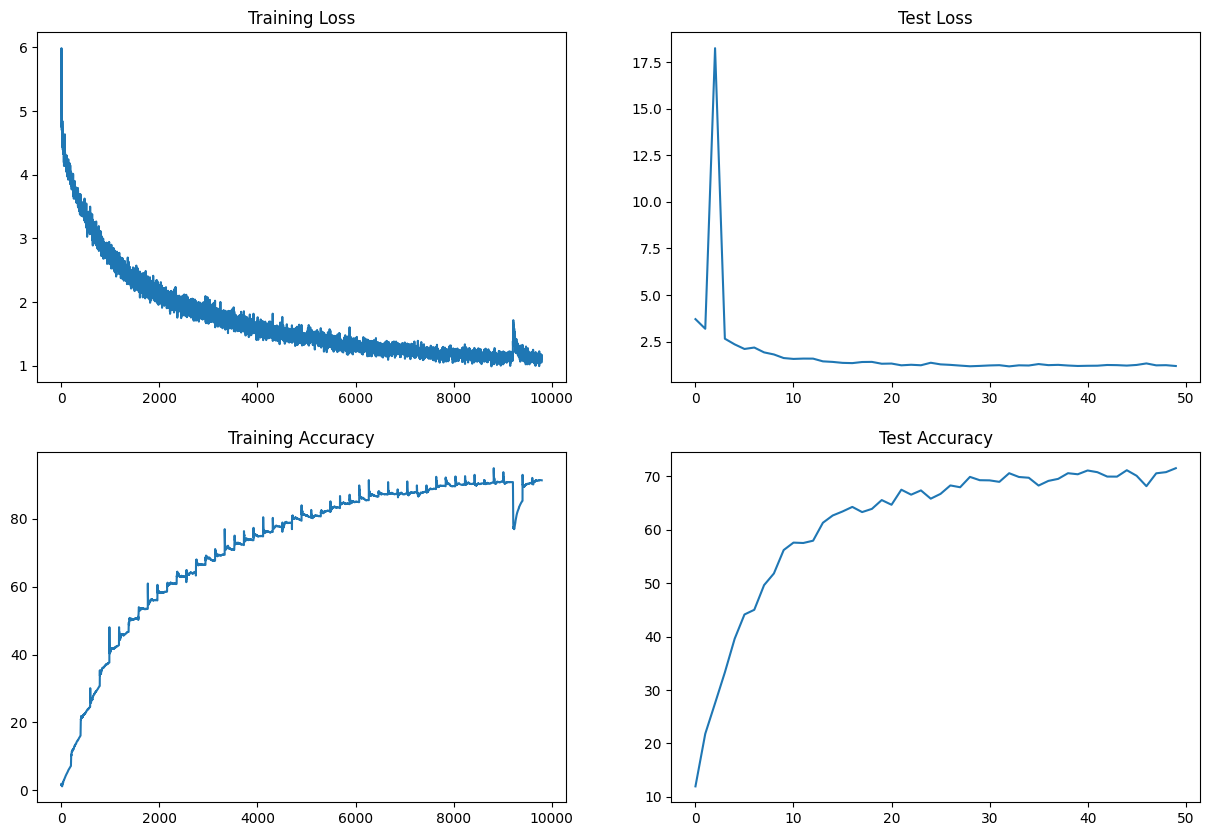

In [104]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [106]:
from google.colab import drive
import torch

drive.mount('/gdrive')
# Save the model's state dictionary
torch.save(model.state_dict(), '/gdrive/My Drive/CIFAR100onResnet50v3.pth')
print("Model saved to /gdrive/My Drive/CIFAR100onResnet50v3.pth")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Model saved to /gdrive/My Drive/CIFAR100onResnet50.pth
